In [3]:
import numpy as np
from sklearn import metrics
import os
import glob
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold 
from sklearn import metrics
from time import time
import pandas as pd
import xgboost as xgb
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import datatable as dt
import warnings
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

from tools import *

In [2]:
base_dir = "../2021_3_data"
test_data_dir  = os.path.join(base_dir, "testdata")
train_data_dir = os.path.join(base_dir, "traindata")

# 将多次提交结果融合为一次

投票、加权投票

In [3]:
subs = glob.glob("../submission*.csv")
subs

['../submission-1625399147.csv',
 '../submission-1625380995.csv',
 '../submission-1625047446.csv',
 '../submission-1625404864.csv',
 '../submission-1625145233.csv',
 '../submission-1625555134.csv',
 '../submission-1625568173.csv',
 '../submission-1624972040.csv',
 '../submission-1625404387.csv',
 '../submission.csv',
 '../submission-1625116622.csv',
 '../submission-1624955107.csv']

In [61]:
", ".join([e.replace("../", "") for e in subs])

'submission-1625399147.csv, submission-1625380995.csv, submission-1625047446.csv, submission-1625404864.csv, submission-1625145233.csv, submission-1625555134.csv, submission-1625568173.csv, submission-1624972040.csv, submission-1625404387.csv, submission.csv, submission-1625116622.csv, submission-1624955107.csv'

In [19]:
watch_label = None
is_share = None
wl_enc = OneHotEncoder(categories=[list(range(10))])
sh_enc = OneHotEncoder(categories=[[0, 1]])
for sub in subs:
    tab = dt.fread(f"{sub}")
    
    if watch_label is None:
        wt = wl_enc.fit_transform(tab[:, 'watch_label'].to_pandas().values)
        watch_label = wt  # np.zeros((len(wt), 10))
#         watch_label[:, wt] = 1
    else:
        wt = wl_enc.transform(tab[:, 'watch_label'].to_pandas().values)
        watch_label += wt 
    
    if is_share is None:
        sh = sh_enc.fit_transform(tab[:, 'is_share'].to_pandas().values)
        is_share = sh
    else:
        sh = sh_enc.transform(tab[:, 'is_share'].to_pandas().values)
        is_share += sh

In [29]:
ensembled_wl = watch_label.toarray().argmax(axis=1)
ensembled_sh = is_share.toarray().argmax(axis=1)
ensembled_wl.shape, ensembled_sh.shape

((2822180,), (2822180,))

In [40]:
tab[:, 'watch_label'] = ensembled_wl
tab[:, 'is_share'] = ensembled_sh
tab.to_pandas().to_csv(f'../submission-{int(time())}.csv', index=False, sep=",")

In [50]:
Counter(ensembled_sh)

Counter({0: 2399328, 1: 422852})

In [51]:
tab.to_pandas().corr()

,user_id,video_id,watch_label,is_share
user_id,1.000000,0.000125,-0.001180,-0.000646
video_id,0.000125,1.000000,-0.015456,0.036990
watch_label,-0.001180,-0.015456,1.000000,0.054857
is_share,-0.000646,0.036990,0.054857,1.000000


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

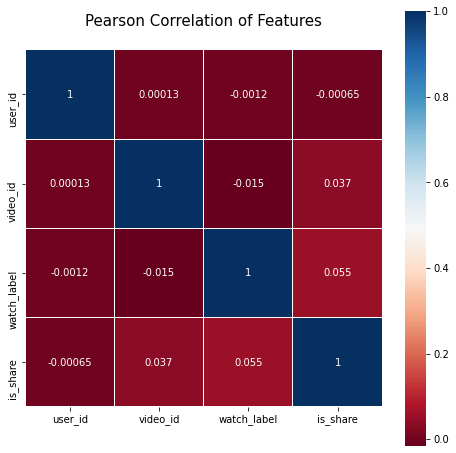

In [58]:
colormap = plt.cm.RdBu
plt.figure(figsize=(8, 8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(tab.to_pandas().corr(), linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

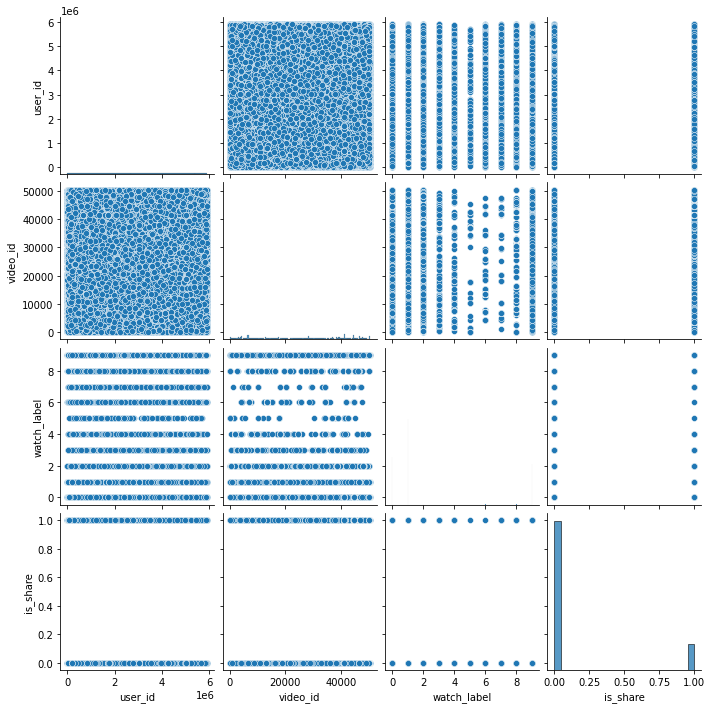

In [59]:
sns.pairplot(tab.to_pandas())

# Stacking
模型融合

以两层的stacking为例，基本思路：
1. 准备好训练数据集data\_tr和测试数据集data\_te
2. 准备好第一层的n个模型
3. 遍历每一个模型$learner_i$：
    1. 在data_tr上进行交叉验证。将data\_tr划分为k折，每次使用k-1折训练，剩下的1折进行验证  
    2. 训练出k个模型 $(learner_{i1}, ..., learner_{ik})$，每个模型会给出1折的预测结果
    
    3. 将k个模型在验证集(剩下的1折)上的预测拼接起来，得到$learner_i$对整个数据集data\_tr的预测
    4. 将k个模型在测试集data\_tr的预测结果求平均，得到$learner_i$对data\_te的预测  
4. 通过步骤3，可以得到n个模型在data\_tr上的预测，按列拼接起来，得到new\_data\_tr
5. 通过步骤3，可以得到n个模型在data\_te上的预测，按列拼接起来，得到new\_data\_te
6. 将new\_data\_tr和new\_data\_te作为新的训练数据和测试数据，训练数据中的训练目标依然为data\_tr的训练目标
7. 在新的训练数据上训练、测试（也可以继续进行stacking）
    

In [69]:
# Class to extend the Sklearn classifier
class ModelWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
# Out-of-Fold Predictions
def get_oof(clf, x_train, y_train, x_test, cv, n_class=10):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain, n_class))
    oof_test = np.zeros((ntest, n_class))
    oof_test_skf = np.empty((cv.n_splits, ntest, n_class))
#     print(oof_train.shape, oof_test.shape, oof_test_skf.shape)
    
    i = 0
    for train_index, test_index in cv.split(x_train, y_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)
        
        pred1 = clf.predict_proba(x_te)
        pred2 = clf.predict_proba(x_test)
#         print(pred1.shape, pred2.shape)
        oof_train[test_index] = pred1
        oof_test_skf[i, :] = pred2
        i += 1
#     print(oof_test_skf.shape)
    oof_test[:] = oof_test_skf.mean(axis=0)
#     print(oof_test.shape)
    return oof_train, oof_test
    

In [71]:
SEED = 0
n_split = 5

In [66]:
# 第一层模型参数
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}


model_params = [rf_params, et_params, ada_params, gb_params, svc_params]
rf = ModelWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = ModelWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = ModelWrapper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = ModelWrapper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = ModelWrapper(clf=SVC, seed=SEED, params=svc_params)
models = [rf, et, ada, gb, svc]

In [72]:
# 加载数据
X_train = None
y_train = None
X_test  = None
cv = StratifiedKFold(n_split, shuffle=True, random_state=SEED)

In [ ]:
new_data_tr = None
new_data_te = None
for i, model in enumerate(models):
    oof_train, oof_test = get_oof(model, X_train, y_train, X_test, cv)
    df = pd.DataFrame(oof_train, columns=[f"{model.__name__}_{i}" for i in range(oof_train.shape[1])])
    if new_data_tr is None:
        new_data_tr = df
    else:
        new_data_tr = pd.concat([new_data_tr, df], axis=1, ignore_index=True)
        
    df = pd.DataFrame(oof_test, columns=[f"{model.__name__}_{i}" for i in range(oof_test.shape[1])])
    if new_data_te is None:
        new_data_te = df
    else:
        new_data_te = pd.concat([new_data_te, df], axis=1, ignore_index=True)
    

In [ ]:
# 第二层模型参数
xgb_params = {
    'objective': 'multi:softmax',
    'eta': 0.1,
    'nthread': 8,
    'num_class': 10,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'eval_metric': ['mlogloss', 'auc', 'merror'],
    'max_depth': 9,
    'min_child_weight': 9,
    'gamma': .3
}
ModelWrapper(clf=xgb.XGBClassifier, seed=SEED, params=xgb_params)

# mlxtend 做Stackin